In [2]:
import pandas as pd

df_2005 = pd.read_excel("State-to-state_mig.xlsx", sheet_name="2005")
df_2005.head()

,Unnamed: 0,Alabama,Unnamed: 2,Alaska,Unnamed: 4,Arizona,Unnamed: 6,Arkansas,Unnamed: 8,California,...,Virginia,Unnamed: 96,Washington,Unnamed: 98,West Virginia,Unnamed: 100,Wisconsin,Unnamed: 102,Wyoming,Unnamed: 104
0,NaN,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,...,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,MOE,Estimate,MOE
1,Alabama,580353,22382,608,432,574,542,3168,1655,3025,...,2572,1142,1324,817,432,467,303,230,436,507
2,Alaska,152,176,84150,6528,883,530,54,83,3898,...,618,537,5711,2516,0,233,765,465,222,353
3,Arizona,1427,784,1836,1443,917186,26917,1845,948,94296,...,4196,2459,10335,2314,527,468,7798,2272,1458,811
4,Arkansas,1894,1228,660,504,1266,617,390364,17198,6167,...,1355,997,1062,1260,59,77,1542,1232,41,71


In [11]:
states_of_interest = ['California', 'Florida', 'New York', 'Georgia', 'Texas']

year_groups = {
    "2005-2008": ["2005", "2006", "2007", "2008"],
    "2009-2012": ["2009", "2010", "2011", "2012"],
    "2013-2016": ["2013", "2014", "2015", "2016"],
    "2017-2018": ["2017", "2018"],
    "2019-2022": ["2019", "2021", "2022"]
}

# construct a dictionary with key = period and value = squared matrix 
aggregated_data = {}

for group, years in year_groups.items():
    aggregated_df = pd.DataFrame(0, index=states_of_interest, columns=states_of_interest)
    for year in years:
        df = pd.read_excel("State-to-state_mig.xlsx", sheet_name=year)
        migration_data = df.set_index("Unnamed: 0").loc[states_of_interest, states_of_interest]
        aggregated_df += migration_data
    aggregated_data[group] = aggregated_df


aggregated_data["2019-2022"]

,California,Florida,New York,Georgia,Texas
California,NaN,75941,101545,34609,112919
Florida,116793,NaN,240447,134394,92624
New York,90348,64720,NaN,22169,42084
Georgia,70305,146778,45214,NaN,67619
Texas,292223,114008,73919,63314,NaN


In [12]:
# Ensure that the diagonal values (self-connections) are set to 0
for group, data in aggregated_data.items():
    for state in states_of_interest:
        data.at[state, state] = 0

aggregated_data["2009-2012"]

,California,Florida,New York,Georgia,Texas
California,0,82229,103954,43732,151778
Florida,87149,0,220790,150862,97815
New York,98477,118164,0,34027,40323
Georgia,55012,178607,53446,0,59748
Texas,251923,131854,76026,73823,0


In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

def plot_gradient_colored_network(data, title):
    """
    Create and plot a directed weighted network with enhanced visuals: 
    - Node colors based on a rescaled custom gradient (light green to blue).
    - Increased edge size.
    """
    
    G = nx.DiGraph()

    # Add nodes
    for state in states_of_interest:
        G.add_node(state)

    # Add weighted edges
    for origin, row in data.iterrows():
        for destination, value in row.items():
            if origin != destination and value != 0:  # Ensure we don't add self-loops
                G.add_edge(origin, destination, weight=value)

    # Calculate the sum of the weights of incoming edges for each node
    incoming_weights = {node: sum([data[neighbor][node] for neighbor in states_of_interest]) for node in G.nodes()}

    # Determine the custom color gradient (light green to blue) based on the incoming weights
    min_weight = min(incoming_weights.values())
    max_weight = max(incoming_weights.values())
    
    # gradient transition from light green to blue
    node_colors = [((1 - (incoming_weights[node] - min_weight) / (max_weight - min_weight)) * np.array([0.6, 1, 0.8]) + 
                    (incoming_weights[node] - min_weight) / (max_weight - min_weight) * np.array([0, 0, 0.9])) for node in G.nodes()]

    # Draw the network using a circular layout
    pos = nx.circular_layout(G)
    plt.figure(figsize=(10, 7))
    
    # Draw nodes 
    nx.draw_networkx_nodes(G, pos, node_size=5000, node_color=node_colors)
    
    # Draw node labels
    nx.draw_networkx_labels(G, pos)
    
    # Draw edges with increased width based on weights and color matching the target node gradient
    edge_widths = [np.sqrt(G[u][v]['weight']) / 250 for u, v in G.edges()]  # Increased edge size
    edge_colors = [((1 - (incoming_weights[v] - min_weight) / (max_weight - min_weight)) * np.array([0.6, 1, 0.8]) + 
                    (incoming_weights[v] - min_weight) / (max_weight - min_weight) * np.array([0, 0, 0.9])) for u, v in G.edges()]
    
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges(), edge_color=edge_colors, width=edge_widths, 
        arrowstyle='-|>', arrowsize=40, connectionstyle="arc3,rad=0.2"  # Enhanced arrow size
    )
    
    plt.title(title)
    plt.axis('off')
    plt.show()

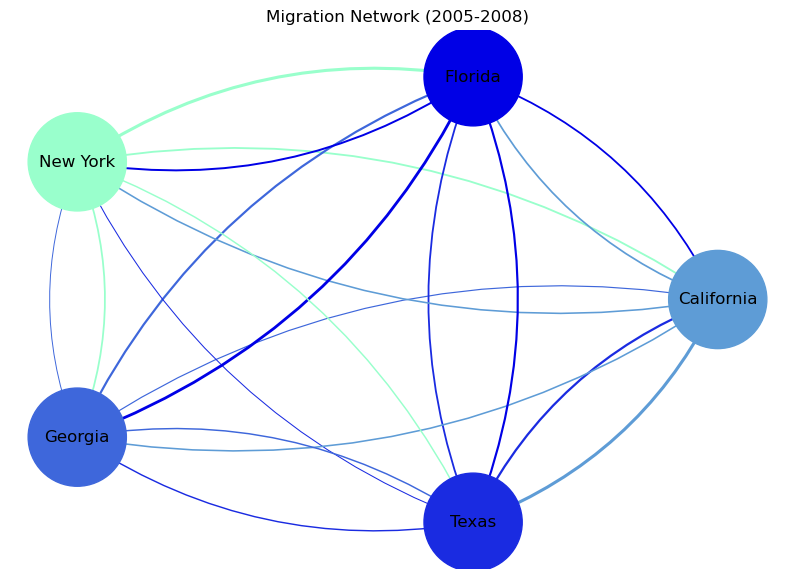

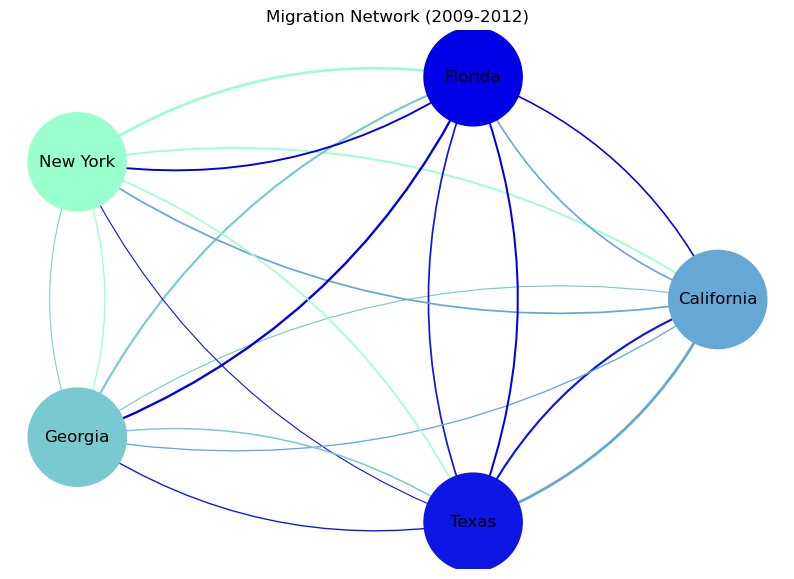

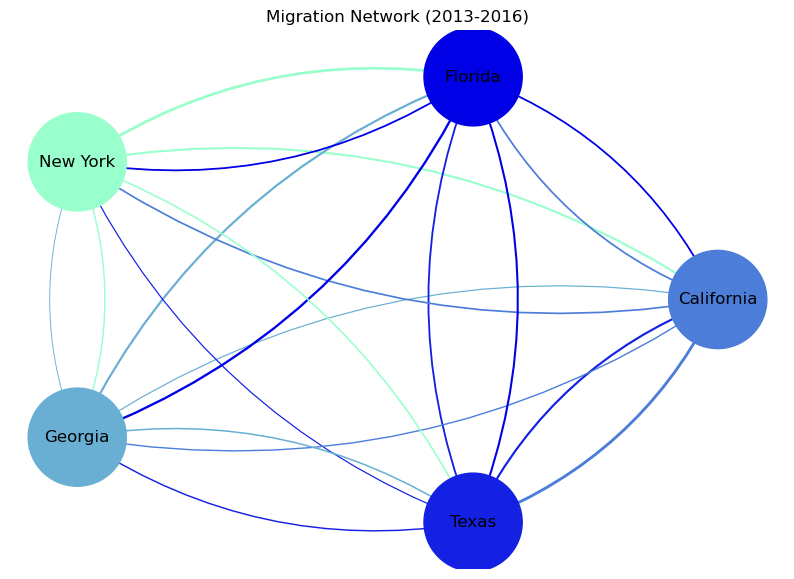

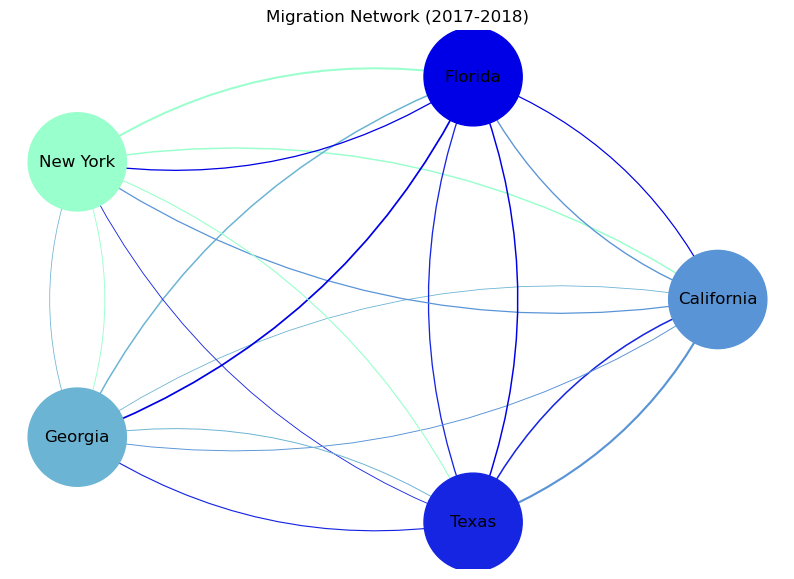

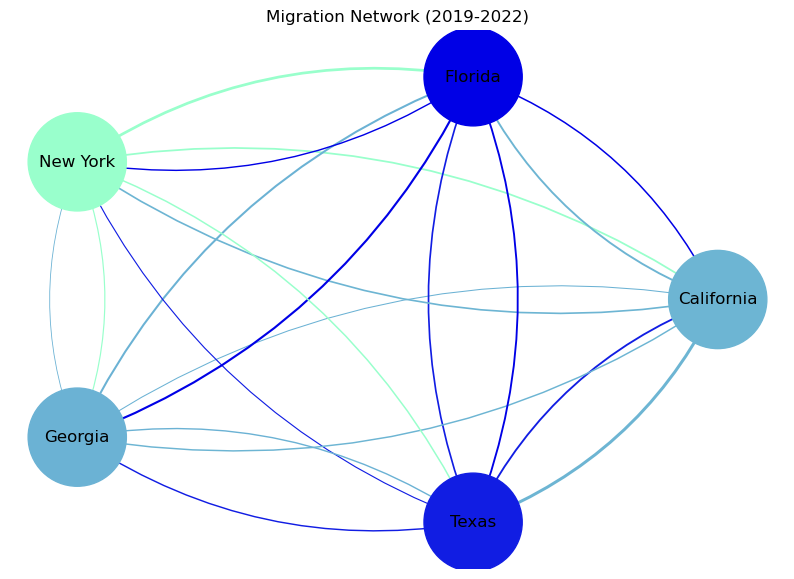

In [14]:
# Visualize all the time periods
for period, data in aggregated_data.items():
    plot_gradient_colored_network(data, f"State-to-stImmigration Network ({period})")